In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import json
import sys
import numpy as np
from scipy.stats import kurtosis, norm
from scipy.special import logsumexp
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm, trange
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp

sys.path.append('../scripts/python')
from parameter_estimation import BivariateBeta
from experiments import starting_experiment, starting_experiment_2

plt.style.use('science')

## Second diagnostic

In [86]:
from autograd import grad
import autograd.numpy as np

def c(x):
    return (x[3] - x[0]*x[1])*x[0]*(1-x[0])/x[2] + (1-x[0])*(1-x[1])

def h(x):
    r = (x[0] + x[1] - 1 + c(x))
    r *= (1 - x[0] - c(x))
    r *= (1 - x[1] - c(x))
    r *= c(x)
    return r

grad_h = grad(h)

def matrix(x,y):
    Lambda = np.zeros((4,4))
    Lambda[:-2,:-2] = np.cov(x,y)
    Lambda[0,2] = Lambda[2,0] = np.cov(x, (x-x.mean())**2)[0,1]
    Lambda[1,2] = Lambda[2,1] = np.cov(y, (x-x.mean())**2)[0,1]
    Lambda[2,2] = np.var((x-x.mean())**2)
    Lambda[0,3] = Lambda[3,0] = np.cov(x, x*y)[0,1]
    Lambda[1,3] = Lambda[3,1] = np.cov(y, x*y)[0,1]
    Lambda[2,3] = Lambda[3,2] = np.cov((x-x.mean())**2, x*y)[0,1]
    Lambda[3,3] = np.var(x*y)
    return Lambda

In [99]:
true_alpha = np.array([2,1,1,1])
n = 100
m1, m2, v1, v2, rho = BivariateBeta(true_alpha).moments()
moments_true = np.array([m1,m2,v1,rho*np.sqrt(v1*v2) + m1*m2])
derivative = grad_h(moments_true)
mean = h(moments_true)
v = []
for i in range(1000):
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    moments_hat = np.array([X.mean(), Y.mean(), X.var(), (X*Y).mean()])
    Lambda = matrix(X,Y)
    v.append(moments_hat)
    #v.append(np.sqrt(n) * (h(moments_hat) - mean) / np.sqrt(derivative @ Lambda @ derivative))

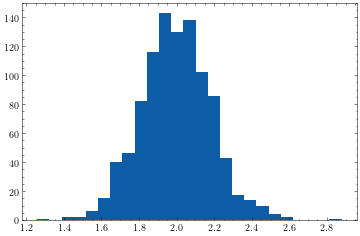

In [100]:
plt.hist(np.sqrt(n)*(np.array(v)[:,3] - rho), bins=25)
plt.show()

In [97]:
np.array(v)[:,3].mean()

0.3666094541150798

In [98]:
rho

0.16666666666666669

In [19]:
rng = np.random.default_rng(671289)
true_alpha = np.array([1e-10,1e-10,2.5,1000.0])
n = 50

k = []
l = []

for i in range(10000):

    U = rng.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    
    m1 = np.mean(X)
    m2 = np.mean(Y)
    v1 = np.var(X, ddof=1)
    rho = np.corrcoef(X, Y)[0,1]
    alpha_hat = BivariateBeta()._system_solution(m1, m2, v1, rho)
    
    l.append(alpha_hat[0])

C:\Users\lucas\anaconda3\envs\project-beta\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\lucas\anaconda3\envs\project-beta\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\lucas\Documents\Github\bivariate-beta\notebooks\../scripts/python\parameter_estimation.py:202: RuntimeWarning: invalid value encountered in double_scalars
  alpha_sum = (m1 - m1*m1)/v1 - 1


In [23]:
X

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

C:\Users\lucas\anaconda3\envs\project-beta\lib\site-packages\matplotlib\axes\_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\lucas\anaconda3\envs\project-beta\lib\site-packages\matplotlib\axes\_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

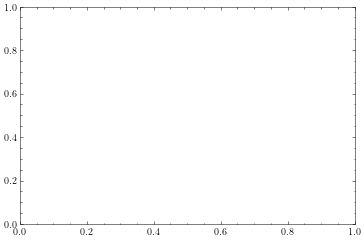

In [20]:
plt.hist(l, bins=50)
plt.axvline(0, color="red", linestyle='--')
plt.show()
print(np.mean(np.array(l)<-0.25))

In [6]:
rng = np.random.default_rng(671289)

true_alpha = np.array([0.2,0.7,2.5,0.9])
n = 50
B = 500

U = rng.dirichlet(true_alpha, size=n)
X = rng.beta(1,3, size=50)
Y = rng.beta(2,5, size=50)

index = rng.choice(range(n), size=(n, B))
Xb = X[index]
Yb = Y[index]

Xb_mean = Xb.mean(axis=0)
Yb_mean = Yb.mean(axis=0)
Xb_var = Xb.var(axis=0, ddof=1)
XbYb_corr = np.corrcoef(Xb.T, Yb.T).diagonal(Xb.shape[1])

alpha_hat = BivariateBeta()._system_solution(Xb_mean, Yb_mean, Xb_var, XbYb_corr)

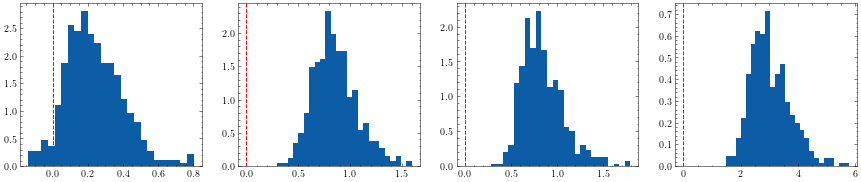

In [7]:
fig, ax = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    ax[i].hist(alpha_hat[i], bins=25, density=True)
    ax[i].axvline(0, linestyle='--', color='red')
plt.show() 

In [8]:
rng = np.random.default_rng(312)

true_alpha = np.array([0.2,0.7,2.5,0.9])
n = 50

S = []
for i in range(1000):

    U = rng.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]

    S.append(BivariateBeta().positive_diagnostic_diagnostic(X,Y))

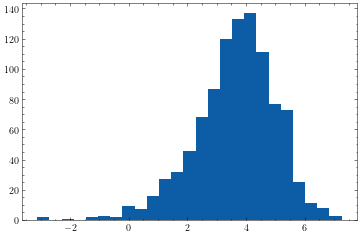

In [9]:
plt.hist(S, bins=25)
plt.show()

## Sensibility of the first diagnostic method

In [10]:
seed = np.random.randint(3219121)
rng = np.random.default_rng(seed)

S1_values = []
S2_values = []

for i in range(2000):

    X = rng.beta(2, 3, size=50)
    Y = rng.beta(1, 3, size=50)

    S1, _ = BivariateBeta().marginal_diagnostic(X,Y, which_g='divisor')
    S2, _ = BivariateBeta().marginal_diagnostic(X,Y, which_g='quadratic')

    S1_values.append(S1)
    S2_values.append(S2)

In [11]:
t = np.linspace(-4,4,1000)

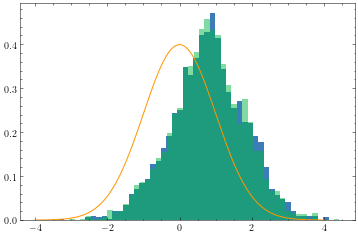

In [12]:
plt.hist(S1_values, bins=50, density=True, alpha=0.8)
plt.hist(S2_values, bins=50, density=True, alpha=0.5)
plt.plot(t, norm.pdf(t))
plt.show()

## Q-Q plot

I first will verify if Assingment problem is equivalent to sorting in the unidimensional setting.

In [52]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(1), cov=np.eye(1), size=n)
y = np.random.multivariate_normal(mean=np.zeros(1), cov=np.eye(1), size=n)

In [53]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = (x[i] - y[j])**2
        
index1_assign, index2_assign = linear_sum_assignment(cost_matrix=C)
index1_sort, index2_sort = np.argsort(x, axis=0), np.argsort(y, axis=0)

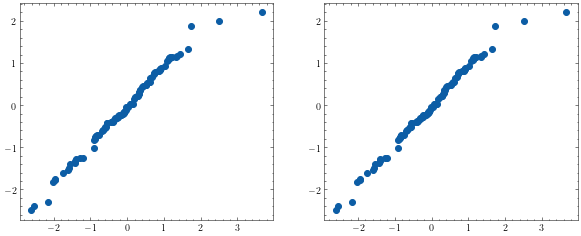

In [60]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x[index1_sort], y[index2_sort])
ax[1].scatter(x[index1_assign], y[index2_assign])
plt.show()

In [90]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
y = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)

In [91]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(x[i] - y[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

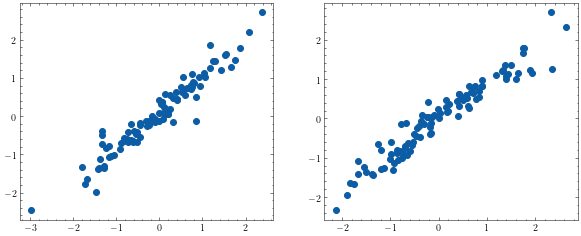

In [92]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(x[index1, 0], y[index2, 0])
ax[1].scatter(x[index1, 1], y[index2, 1])
plt.show()

The above graphic is called **fuzzy Q-Q plot**

## Well-specified case

In [147]:
rng = np.random.default_rng(61289)

true_alpha = np.array([2,7,3,1])
n = 100

U = rng.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

alpha_hat = BivariateBeta().method_moments_estimator_4(X,Y,alpha0=(1,1,1,1))
U = rng.dirichlet(true_alpha, size=n)
X_hat = U[:,0] + U[:,1]
Y_hat = U[:,0] + U[:,2]
XY_hat = np.column_stack([X_hat, Y_hat])

C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(XY[i] - XY_hat[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

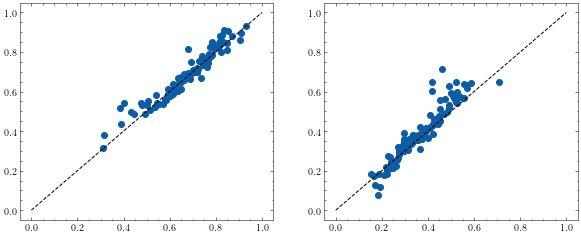

In [148]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(XY[index1, 0], XY_hat[index2, 0])
ax[1].scatter(XY[index1, 1], XY_hat[index2, 1])
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

## Wrongly specified case

In [145]:
rng = np.random.default_rng(671289)
n = 100

X = rng.beta(1,3, size=n)
Y = rng.beta(4,5, size=n)
XY = np.column_stack([X,Y])

alpha_hat = BivariateBeta().method_moments_estimator_4(X,Y,alpha0=(1,1,1,1))
U = rng.dirichlet(alpha_hat, size=n)
X_hat = U[:,0] + U[:,1]
Y_hat = U[:,0] + U[:,2]
XY_hat = np.column_stack([X_hat, Y_hat])

C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(XY[i] - XY_hat[j], ord=2)
        
index1, index2 = linear_sum_assignment(cost_matrix=C)

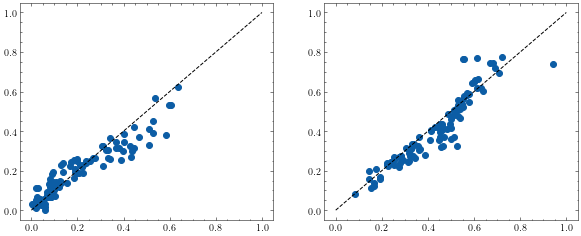

In [146]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].scatter(XY[index1, 0], XY_hat[index2, 0])
ax[1].scatter(XY[index1, 1], XY_hat[index2, 1])
ax[0].plot([0, 1], [0, 1], color='black', linestyle='--')
ax[1].plot([0, 1], [0, 1], color='black', linestyle='--')
plt.show()

In [144]:
print(alpha_hat[0]+alpha_hat[1], alpha_hat[2]+alpha_hat[3])
print(alpha_hat[0]+alpha_hat[2], alpha_hat[1]+alpha_hat[3])

1.298768545820208 4.913490724613205
1.5077445344173208 4.704514736016093


## Distance Q-Q Plot

In [182]:
n = 100
x = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
y = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)

In [187]:
C = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C[i,j] = np.linalg.norm(x[i] - y[j], ord=2)
index1, index2 = linear_sum_assignment(cost_matrix=C)

distances1 = np.sort(C[index1, index2])

distances2 = np.zeros(100)

for k in range(50):
    z = np.random.multivariate_normal(mean=np.zeros(2), cov=np.eye(2), size=n)
    C = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            C[i,j] = np.linalg.norm(x[i] - z[j], ord=2)
    index1, index2 = linear_sum_assignment(cost_matrix=C)

    distances2 = (k * distances2 + np.sort(C[index1, index2]))/(k+1)

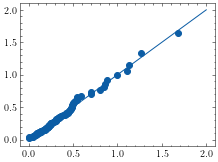

In [188]:
plt.scatter(distances1, distances2)
plt.plot([0,2], [0,2])
plt.show()